In [1]:
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import matplotlib.patches as mpatches
%matplotlib inline

# Plot Parameters

In [2]:
#parameters
plotdir = "./plots"
font = { 'size'   : 15}
plt.rc('font', **font)
markersize = 10 #12

#markers
colors = ['b','r','g','m','y','c']
styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

#styledict
styledict = {"thorsten": {"fontsize_annotation": 10, "roof_color": 'gray', "legend_points_ncol": 2, "frameon": False}, 
             "charlene": {"fontsize_annotation": 15, "roof_color": 'k', "legend_points_ncol": 1, "frameon": True}}

# Plot Code

In [3]:
#plot time
#plot_data(file_prefix, plot_label, marker_tag, marker_label, df):
def plot_time(file_prefix, plot_label, marker_tag, marker_label, df):

    def byte2time(x):
        return x / byteroofs[0]


    def flop2time(y):
        return y / floproofs[-1]

    #pick style:
    style = styledict["thorsten"]
    fontsize_annotation = style["fontsize_annotation"]

    df[['FLOPs', 'DRAM Bytes']] /= 1e9
    
    lbytes  = list(df["DRAM Bytes"])
    lflops  = list(df["FLOPs"])
    ltime   = list(df["CUDA Time"])
    lcalls  = list(df["Invocations"])
    llabels = list(df[marker_tag])
    lfids   = list(df["Framework"])
    lprecs  = list(df["Precision"])
    
    tmp_labels = df[marker_tag].unique()
    tmp_labels.sort()
    #print(tmp_labels)
    dic = {}
    id = 0
    for x in tmp_labels:
        dic[x] = id
        id += 1
    
    numkernels = len(llabels)

    #figure stuff
    fig = plt.figure(1, figsize=(10, 10))
    plt.clf()
    ax = fig.gca()
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('GBytes')
    ax.set_ylabel('GFLOPs')

    #ax.grid(True, which="major", ls="--", lw=1)
    #ax.grid(True, which="minor", ls="--", lw=0.5)

    bmin = min(lbytes)
    bmax = max(lbytes)
    fmin = min(lflops)
    fmax = max(lflops)
    tmin = min(ltime)
    tmax = max(ltime)
    tmax = math.ceil(tmax)

    # kernel launch overhead is ~ 4.2 us
    overhead = 4.2e-6
    
    
    #mem
    byteroofs = [828.8, 2996.7, 14*1024]
    byteroofnames = ['HBM', 'L2', 'L1']

    #flops
    floproofs = [7669.1, 15158.2, 29181.6, 106490.0]
    floproofnames = ['FP64', 'FP32', 'FP16', 'TC']

    # max time ceilings
    mt_byteroof = byteroofs[0] * tmax
    mt_floproof = floproofs[-1] * tmax
    
    balance = floproofs[-1] / byteroofs[0]
    
    
    min_flop_ceiling, min_byte_ceiling = float("inf"), float("inf")
    
    # plot overheads
    for i in range(len(lcalls)):
        tmp_overhead = lcalls[i] * overhead
        
        # overhead ceilings
        oh_byteroof = byteroofs[0] * tmp_overhead
        oh_floproof = floproofs[-1] * tmp_overhead
        
        # plot memory ceilings
        ax.plot([oh_byteroof, oh_byteroof], [0, oh_floproof], c=colors[int(lfids[i])], linestyle='--')
        # plot flop ceilings
        ax.plot([0, oh_byteroof], [oh_floproof, oh_floproof], c=colors[int(lfids[i])], linestyle='--')
        
        min_flop_ceiling, min_byte_ceiling = min(min_flop_ceiling, oh_floproof), min(min_byte_ceiling, oh_byteroof)
        
    max_flop_ceiling, max_byte_ceiling = 0.0, 0.0
    
    for i in range(len(lbytes)):
        if lprecs[i] == 0:
            ax.plot(float(lbytes[i]),float(lflops[i]), c=colors[int(lfids[i])], marker=styles[dic[llabels[i]]], mfc='none', linestyle='None', ms=markersize)
        else:
            ax.plot(float(lbytes[i]),float(lflops[i]), c=colors[int(lfids[i])], marker=styles[dic[llabels[i]]], linestyle='None', ms=markersize)
        local_balance = float(lflops[i]) / float(lbytes[i])

        flop_ceilings, byte_ceilings = [], []
        for flop in floproofs:
            flop_ceilings.append(ltime[i] * flop)
            byte_ceilings.append(ltime[i] * flop / local_balance)
        
        # compute bound
        if local_balance > balance:
            flop_vertex = ltime[i] * floproofs[-1]
            byte_vertex = flop_vertex / local_balance
            
            label = floproofnames[-1]
            #ax.annotate(label, xy=(byte_vertex, flop_vertex), xytext=(5,0), textcoords="offset points",
            #            color=colors[int(lfids[i])], horizontalalignment='left', fontsize=fontsize_annotation)
        # memory bound
        else:
            byte_vertex = ltime[i] * byteroofs[0]
            flop_vertex = byte_vertex * local_balance
        
        if lprecs[i] == 0:
            ax.plot(byte_vertex,flop_vertex, c=colors[int(lfids[i])], marker=styles[dic[llabels[i]]], mfc='none', linestyle='None', ms=markersize)
        else:
            ax.plot(byte_vertex,flop_vertex, c=colors[int(lfids[i])], marker=styles[dic[llabels[i]]], linestyle='None', ms=markersize)
        ax.plot([lbytes[i], byte_vertex], [lflops[i], flop_vertex], c=colors[int(lfids[i])])
        if local_balance < balance:
            label = byteroofnames[0] #+ ' {0:.1f}'.format(float(flop_ceiling))
            #ax.annotate(label, xy=(byte_vertex, flop_vertex), xytext=(5,10), textcoords="offset points",
            #                    color=colors[int(lfids[i])], horizontalalignment='left', fontsize=fontsize_annotation)
        
        min_flop_ceiling, min_byte_ceiling = min(min_flop_ceiling, lflops[i]), min(min_byte_ceiling, lbytes[i])
        max_flop_ceiling, max_byte_ceiling = max(max_flop_ceiling, flop_vertex), max(max_byte_ceiling, byte_vertex)

        # plot flop ceilings
        #for j in range(len(flop_ceilings)):
        #    if (lflops[i] <= flop_ceilings[j] < flop_vertex) and (lbytes[i] <= byte_ceilings[j] < byte_vertex):
        #        ax.plot(byte_ceilings[j],flop_ceilings[j], c=colors[int(lfids[i])], marker=styles[dic[llabels[i]]], linestyle='None', ms=5)
        #        label = floproofnames[j] #+ ' {0:.1f}'.format(float(flop_ceiling))
        #        ax.annotate(label, xy=(byte_ceilings[j], flop_ceilings[j]), xytext=(5,-10), textcoords="offset points",
        #                    color=colors[int(lfids[i])], horizontalalignment='left', fontsize=fontsize_annotation)
    
    bmin = pow(10, math.log(min_byte_ceiling)//math.log(10))
    fmin = pow(10, math.log(min_flop_ceiling)//math.log(10)) 
    bmax = pow(10, math.log(max_byte_ceiling)//math.log(10) + 1)
    fmax = pow(10, math.log(max_flop_ceiling)//math.log(10) + 1)

    ax.plot([min_byte_ceiling, mt_byteroof*100], [min_flop_ceiling, mt_floproof*100], c='k')

    bsecax = ax.secondary_xaxis('top', functions=(byte2time, flop2time))
    bsecax.set_xlabel('Byte time (seconds)')
    
    fsecax = ax.secondary_yaxis('right', functions=(flop2time, byte2time))
    fsecax.set_ylabel('FLOP time (seconds)')

    ax.set_xlim(bmin, bmax)
    ax.set_ylim(fmin, fmax)
    
    marker_handles = []
    
    for i in range(len(tmp_labels)):
        marker_handles.append(ax.plot([],[],c='gray',marker=styles[i], mfc='none', linestyle='None',ms=markersize,label="FP32 "+marker_label+" "+str(tmp_labels[i]))[0])
    for i in range(len(tmp_labels)):  
        marker_handles.append(ax.plot([],[],c='gray',marker=styles[i], linestyle='None',ms=markersize,label="FP16 "+marker_label+" "+str(tmp_labels[i]))[0])
    
    #annotations
    #legend 1
    leg1 = plt.legend(handles = marker_handles, loc="lower right", ncol=style["legend_points_ncol"], frameon=style["frameon"])
    ax.add_artist(leg1)

    #legend 2:
    patch_handles = []
    patch_handles.append(mpatches.Patch(color=colors[0],label = 'PT'))
    patch_handles.append(mpatches.Patch(color=colors[1],label = 'TF1'))
    patch_handles.append(mpatches.Patch(color=colors[2],label = 'TF2'))
    leg2 = plt.legend(handles = patch_handles,loc='upper left', scatterpoints = 1, frameon=style["frameon"])

    #save figure
    file_prefix = file_prefix+'_time'
    plt.tight_layout()
    #plt.savefig(file_prefix+'.png')
    plt.savefig(file_prefix+'.eps')

# Load Data

In [4]:
tf1_datadir = "/global/cfs/cdirs/m1759/yswang/results/conv2d-tf1-noxla"
tf2_datadir = "/global/cfs/cdirs/m1759/yswang/results/conv2d-tf2-noxla"
pt_datadir = "/global/cfs/cdirs/m1759/yswang/results/conv2d-pt"
outputdir = "/global/cfs/cdirs/m1759/yswang/plots/summary/"
tf1df = pd.read_csv(os.path.join(tf1_datadir,"combined_profile.csv"))
tf2df = pd.read_csv(os.path.join(tf2_datadir,"combined_profile.csv"))
ptdf = pd.read_csv(os.path.join(pt_datadir,"combined_profile.csv"))
combineddf = pd.concat([tf1df, tf2df, ptdf])

In [5]:
def fill_fid(row):
    if row['Framework'] == 'PT':
        return 0
    if row['Framework'] == 'TF1':
        return 1
    if row['Framework'] == 'TF2':
        return 2

def fill_pid(row):
    if row['Precision'] == 'FP32':
        return 0
    if row['Precision'] == 'FP16':
        return 1

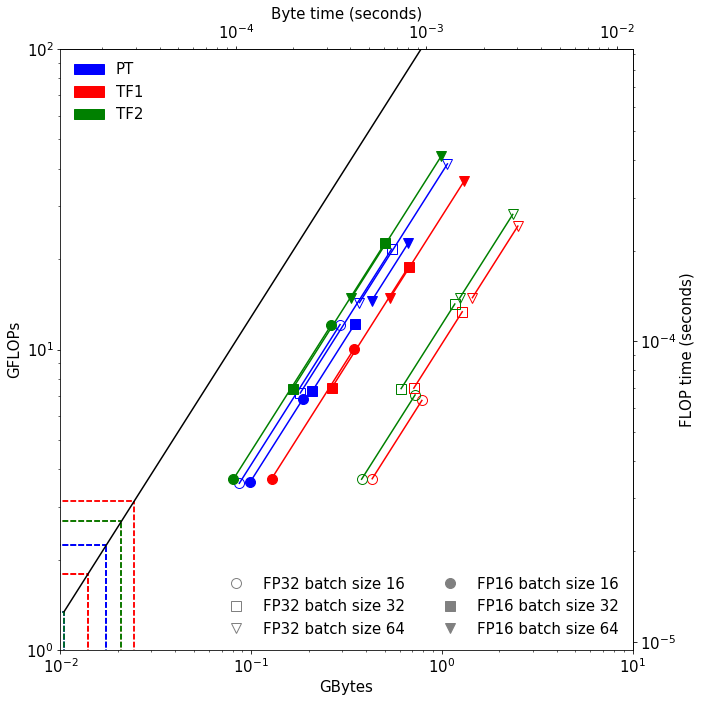

In [6]:
#plot vs batchsize
directory= outputdir
try:
    os.stat(directory)
except:
    os.mkdir(directory)
    
features = list(combineddf[["Network Name", "Input Shape", "Kernel Shape", "Stride Size", "Pass"]].apply(lambda x: (x["Network Name"], \
                                                                                          x["Input Shape"], \
                                                                                          x["Kernel Shape"], \
                                                                                          x["Stride Size"], \
                                                                                          x["Pass"]), axis=1).unique())

for idx,feature in enumerate(features):
    
    #project the data
    selectdf = combineddf[ (combineddf[ "Network Name" ] == feature[0]) & \
                           (combineddf[ "Input Shape" ] == feature[1]) & \
                           (combineddf[ "Kernel Shape" ] == feature[2]) & \
                           (combineddf[ "Stride Size" ] == feature[3]) & \
                           (combineddf[ "Pass" ] == feature[4]) ]
    
    if len(selectdf["Batch Size"].unique()) == 1:
        continue
    
    #label
    plot_label = 'conv2d_time, '+feature[0].split("-")[0]+', '+feature[1]+', '+feature[2]+', '+str(feature[3])+', '+feature[4]
    plot_file = os.path.join(directory, plot_label.replace(", ","_"))
    plot_label = None
    tmpdf = selectdf[['Batch Size', 'Precision', 'Framework', 'CUDA Time', 'DRAM Bytes', "FLOPs", "Invocations"]].copy()
    tmpdf['Framework'] = tmpdf.apply(lambda row : fill_fid(row), axis=1)
    tmpdf['Precision'] = tmpdf.apply(lambda row : fill_pid(row), axis=1) 
    tmpdf.sort_values(by=['Batch Size', 'Precision', 'Framework'], inplace=True)
    #display(tmpdf)
    plot_time(plot_file, plot_label, "Batch Size", "batch size", tmpdf)

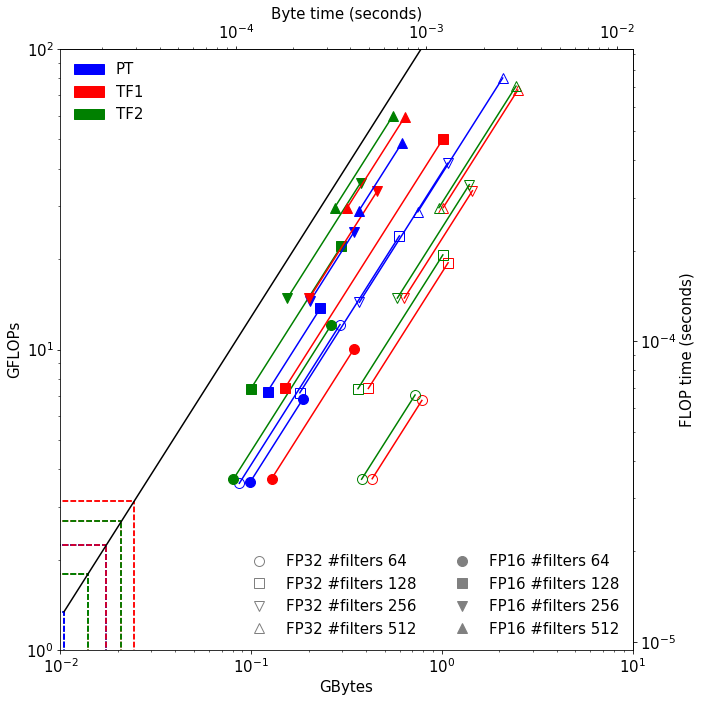

In [7]:
#plot vs num filters
directory= outputdir
try:
    os.stat(directory)
except:
    os.mkdir(directory)

features = list(combineddf[["Network Name", "Input Shape", "Batch Size", "Stride Size", "Pass", "Kernel Shape"]].apply(lambda x: (x["Network Name"], \
                                                                                          x["Input Shape"], \
                                                                                          x["Batch Size"], \
                                                                                          x["Stride Size"], \
                                                                                          x["Pass"], \
                                                                                          x["Kernel Shape"].split("x")[-1], \
                                                                                          "x".join(x["Kernel Shape"].split("x")[:-1])), axis=1).unique())

#do the plotting
for idx,feature in enumerate(features):
    
    #project the data
    selectdf = combineddf[ (combineddf[ "Network Name" ] == feature[0]) & \
                           (combineddf[ "Input Shape" ] == feature[1]) & \
                           (combineddf[ "Batch Size" ] == feature[2]) & \
                           (combineddf[ "Stride Size" ] == feature[3]) & \
                           (combineddf[ "Pass" ] == feature[4]) & \
                           (combineddf[ "Kernel Shape" ].str.startswith(feature[6]))].copy()
    selectdf[ "Num Filters" ] = selectdf["Kernel Shape"].str.split("x").apply(lambda x: int(x[-1]))
    
    #sort data
    selectdf.sort_values("Num Filters", ascending=True, inplace=True)
    
    if len(selectdf["Kernel Shape"].unique()) == 1:
        continue
    
    #label
    plot_label = 'conv2d_time, '+feature[0].split("-")[0]+', '+feature[1]+', '+feature[6]+', '+str(feature[2])+', '+str(feature[3])+', '+feature[4]
    plot_file = os.path.join(directory, plot_label.replace(", ","_"))
    plot_label = None
    tmpdf = selectdf[['Num Filters', 'Precision', 'Framework', 'CUDA Time', 'DRAM Bytes', "FLOPs", "Invocations"]].copy()
    tmpdf['Framework'] = tmpdf.apply(lambda row : fill_fid(row), axis=1)
    tmpdf['Precision'] = tmpdf.apply(lambda row : fill_pid(row), axis=1) 
    tmpdf.sort_values(by=['Num Filters', 'Precision', 'Framework'], inplace=True)
    #display(tmpdf)
    plot_time(plot_file, plot_label, "Num Filters", "#filters", tmpdf)

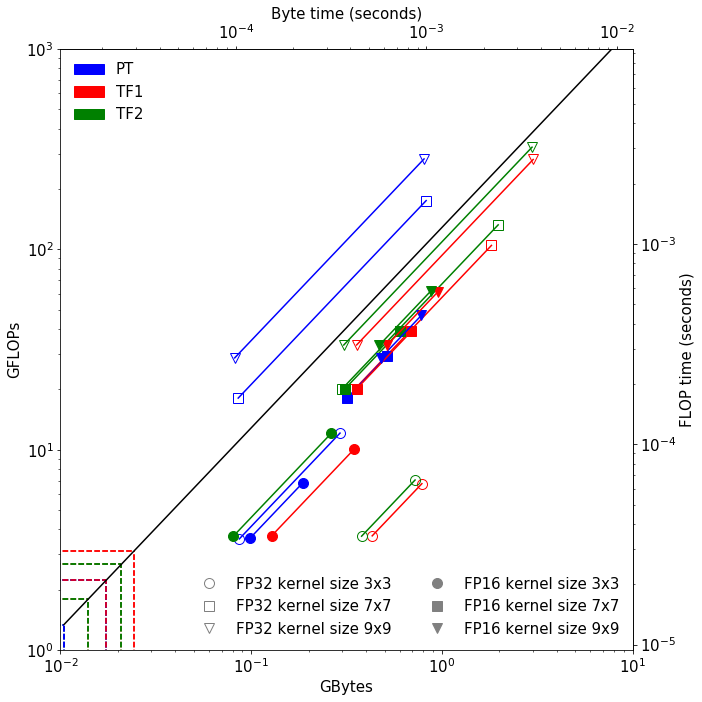

In [8]:
#plot vs kernel size
directory= outputdir
try:
    os.stat(directory)
except:
    os.mkdir(directory)

features = list(combineddf[["Network Name", "Input Shape", "Batch Size", "Stride Size", "Pass", "Kernel Shape"]].apply(lambda x: (x["Network Name"], \
                                                                                          x["Input Shape"], \
                                                                                          x["Batch Size"], \
                                                                                          x["Stride Size"], \
                                                                                          x["Pass"], \
                                                                                          x["Kernel Shape"].split("x")[-1], \
                                                                                          "x".join(x["Kernel Shape"].split("x")[:-1])), axis=1).unique())

#do the plotting
for idx,feature in enumerate(features):
    
    #project the data
    selectdf = combineddf[ (combineddf[ "Network Name" ] == feature[0]) & \
                           (combineddf[ "Input Shape" ] == feature[1]) & \
                           (combineddf[ "Batch Size" ] == feature[2]) & \
                           (combineddf[ "Stride Size" ] == feature[3]) & \
                           (combineddf[ "Pass" ] == feature[4])].copy()
    selectdf[ "Num Filters" ] = selectdf["Kernel Shape"].str.split("x").apply(lambda x: int(x[-1]))
    selectdf[ "Kernel Size" ] = selectdf["Kernel Shape"].str.split("x").apply(lambda x: "x".join(x[:-2]))
    selectdf = selectdf[ selectdf["Num Filters"] == int(feature[5]) ]
    
    #sort data
    selectdf.sort_values("Kernel Size", ascending=True, inplace=True)
    
    if len(selectdf["Kernel Shape"].unique()) == 1:
        continue
    
    #label
    plot_label = 'conv2d_time, '+feature[0].split("-")[0]+', '+feature[1]+', '+feature[5]+', '+str(feature[2])+', '+str(feature[3])+', '+feature[4]
    plot_file = os.path.join(directory, plot_label.replace(", ","_"))
    plot_label = None
    tmpdf = selectdf[['Kernel Size', 'Precision', 'Framework', 'CUDA Time', 'DRAM Bytes', "FLOPs", "Invocations"]].copy()
    tmpdf['Framework'] = tmpdf.apply(lambda row : fill_fid(row), axis=1)
    tmpdf['Precision'] = tmpdf.apply(lambda row : fill_pid(row), axis=1) 
    tmpdf.sort_values(by=['Kernel Size', 'Precision', 'Framework'], inplace=True)
    #display(tmpdf)
    plot_time(plot_file, plot_label, "Kernel Size", "kernel size", tmpdf)

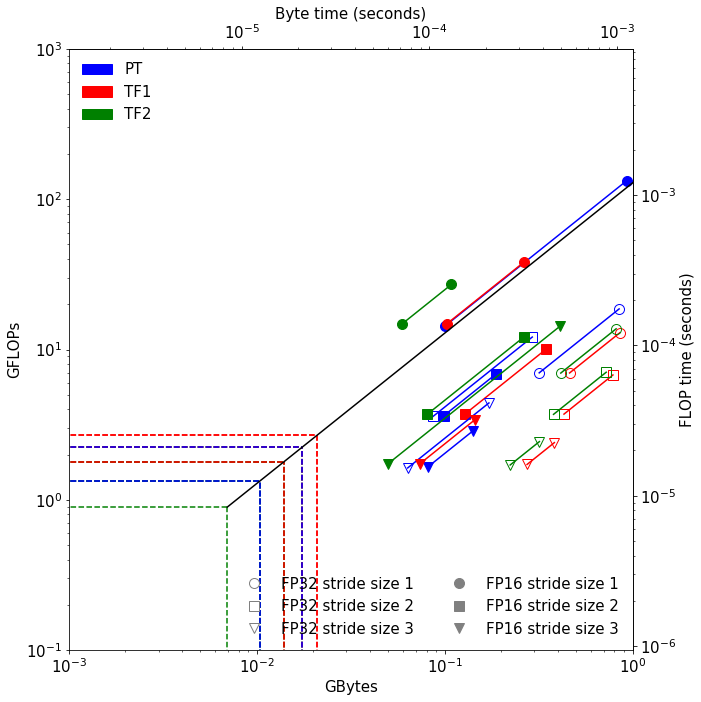

In [9]:
#plot vs stride size
directory= outputdir
try:
    os.stat(directory)
except:
    os.mkdir(directory)

features = list(combineddf[["Network Name", "Input Shape", "Batch Size", "Kernel Shape", "Pass"]].apply(lambda x: (x["Network Name"], \
                                                                                          x["Input Shape"], \
                                                                                          x["Batch Size"], \
                                                                                          x["Kernel Shape"], \
                                                                                          x["Pass"]), axis=1).unique())

#do the plotting
for idx,feature in enumerate(features):
    
    #project the data
    selectdf = combineddf[ (combineddf[ "Network Name" ] == feature[0]) & \
                           (combineddf[ "Input Shape" ] == feature[1]) & \
                           (combineddf[ "Batch Size" ] == feature[2]) & \
                           (combineddf[ "Kernel Shape" ] == feature[3]) & \
                           (combineddf[ "Pass" ] == feature[4])].copy()
    
    #sort data
    selectdf.sort_values("Stride Size", ascending=True, inplace=True)
    
    if len(selectdf["Stride Size"].unique()) == 1:
        continue
    
    #label
    plot_label = 'conv2d_time, '+feature[0].split("-")[0]+', '+feature[1]+', '+feature[3]+', '+str(feature[2])+', '+feature[4]
    plot_file = os.path.join(directory, plot_label.replace(", ","_"))
    plot_label = None
    tmpdf = selectdf[['Stride Size', 'Precision', 'Framework', 'CUDA Time', 'DRAM Bytes', "FLOPs", "Invocations"]].copy()
    tmpdf['Framework'] = tmpdf.apply(lambda row : fill_fid(row), axis=1)
    tmpdf['Precision'] = tmpdf.apply(lambda row : fill_pid(row), axis=1) 
    tmpdf.sort_values(by=['Stride Size', 'Precision', 'Framework'], inplace=True)
    #display(tmpdf)
    plot_time(plot_file, plot_label, "Stride Size", "stride size", tmpdf)

In [10]:
combineddf.loc[ (combineddf["Network Name"] == "ResNet50-2") &\
            (combineddf["Input Shape"] == "112x112x64") &\
            (combineddf["Kernel Shape"] == "9x9x64x64") & \
            (combineddf["Precision"] == "FP16") & \
            (combineddf["Pass"] == "backward")]

,Precision,Network Name,Data Format,Input Shape,Kernel Shape,Stride Size,Batch Size,Pass,CUDA Time,Invocations,...,TC L1 AI,L2 AI,FP32 L2 AI,FP16 L2 AI,TC L2 AI,DRAM AI,FP32 DRAM AI,FP16 DRAM AI,TC DRAM AI,Framework
18,FP16,ResNet50-2,NHWC,112x112x64,9x9x64x64,2,16,backward,0.004614,5,...,0.000000,32.576117,32.072793,0.503325,0.000000,181.038392,178.241217,2.797174,0.000000,TF1
18,FP16,ResNet50-2,NHWC,112x112x64,9x9x64x64,2,16,backward,0.011840,28,...,6.154255,34.084986,12.197090,0.192358,21.695537,193.405941,69.209058,1.091486,123.105398,TF2
18,FP16,ResNet50-2,NHWC,112x112x64,9x9x64x64,2,16,backward,0.005545,15,...,3.724993,77.886376,52.158174,0.027945,25.700257,166.673977,111.616572,0.059800,54.997605,PT
